# UpX Estimation for Peak of Single Sensor

#TODO rewrite this 

Determining the distribution of a signal is difficult. 

The Gaussian distribution used to be used to predict long term peak wind speeds, however the Generalized Extreme Value Distribution (Fischer and Tippet/von Mises) later became the standard method for determining the distribution of peaks in a sample. 

The GEV models the tail of the distribution with one of 3 different distributions. The type 1 distribution (Gumbel) is usually used to model the parent distribution of extreme wind speeds.

A property of the gumbel distribution is that it is possible to derive a simple linear relationship between the probability and peak values using what is known as the reduced variate.
The cumulative probability distribution $F_U(U)$
\begin{align}
F_U(U) &= e^{-e^{-(U-u)/a}}
\end{align}
linearising yields the reduced viariate:
\begin{align}
\text{reduced variate} &= -ln(-ln(F_U))
\end{align}


The up-crossing method or the level-crossing method is a method for estimating the peak value of a stationary stochastic processes and uses the linear relationship between peak value and probability of the gumbel distribution. The method was developed by a guy named Rice. 

The idea is that level-crossing rates (i.e. the number of times that a random process crosses a level (upward or downward) over a certain interval) will have a distribution that can be inferred from relatively few samples. This allows you to etimate the peak value from the distribution for a given probability with relatively little data. 

The level crossings (not rates) are assumed to be modelled by a Poisson Distribution and hence are assumed to be uncorrelated. 

The probability that a level will be the largest level crossed in a given time T can then be shown to be a Type I Extreme Value Distribution.

In this case it is used to estimate the peak pressure recorded from a pressure sensor.

In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats


In [3]:
# plot params
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 14
sns.set()

In [4]:
#constants
TEST_DATA_PATH = "data/WD779E000TT.dat"
TEST_DATA_SUMMARY_PATH = "data/WD779E000.dat"
TEST_DATA_SAMPLE_RATE = 1024  # 1024 samples per second
TEST_DATA_SAMPLE_LEN = 32     # 32 second sample window
TEST_DATA_CHANNEL = 0         # channel of data used. There are 778 sensors in the test data file
TEST_DATA_isUpX = True

K = 0.5772 # the Euler Constant (used later for estimating the hourly peak) 

In [7]:
# utils
def build_linear_model(y, x, add_constant=True):
        '''
            Linear regression model
            returns the fit model
        '''
        if add_constant:
            x = sm.add_constant(x)

        model = sm.OLS(y, x).fit()
        return model 

In [25]:
#todo put everything in a class

class PressureSensor(object):
    """
    Pressure Sensor Class
     - store signal data
     - plotting functions
     - calculate peak
     
     signal data comes from csv 
         - note the summary file is supplied but not really necessary
     
     plotting functions include 
         - plot signal (timeseries)
         - plot distribution (histogram)
         - visualise (combines signal and distribution)
         - plot diagnostics (plots signal, distribution, as well as auto/partial correlation plots)
         - plot peak fit
         
    calculate peak determines the peak 
        - determine peak from level crossing method
            - plot peak fit 
            - include crossings df 
            - 
        - TODO: include other methods for comparison
         
    """
    
    def __init__(self, data_file_path, summary_file_path, channel=0, sample_rate=1024):
        self.data_file_path = data_file_path
        self.summary_file_path = summary_file_path
        self.channel = channel
        self.sample_rate = sample_rate
        
        self.signal = self.load_signal_data()
        self.summary = self.load_summary_data() # this is only used to validate the python against the LabView calcs
        
        self.sample_len = self.signal.index[-1]
        
        self.upX_crossings = self._build_crossings_df(isUpX=True)
        self.dnX_crossings = self._build_crossings_df(isUpX=False)
        
        
    def load_signal_data(self):
        """ load the signal data from self.data_file_path """
        signal_df = pd.read_table(self.data_file_path, 
                                  header=None, 
                                  skipinitialspace=True, 
                                  usecols=[self.channel])
        signal_df.columns = ['signal']
        
        # create time vector for index
        signal_df['time'] = (signal_df.index + 1)/ self.sample_rate
        signal_df.set_index('time', inplace=True)
    
        return signal_df
        
    
    def load_summary_data(self):   
        """ 
        load the summary data
        
        this isn't really necessary except that the post process using LabView 
        uses these values which are rounded
        
        """
        summary_df = pd.read_table(self.summary_file_path, 
                                   skipinitialspace=True, 
                                   skiprows=lambda x: x not in [1, self.channel+2]).T # transpose to match df.describe()
        summary_df.columns=['signal'] # to match regular describe function
        summary_df.index = summary_df.index.str.lower() # to match regular describe function
        return summary_df
    
    
    def _check_summary_file(self, verbose=False):
        """ checking the summary file mean and std against the calculated mean and std from the signal file """
        # TODO: Store this
        _mean = self.signal['signal'].mean()
        _std = self.signal['signal'].std()
        
        if verbose:
            _labview_mean = self.summary.loc['mean'][0]
            _labview_std = self.summary.loc['std'][0]
        
            print(f"% discrepancy in mean\t: {100*(_labview_mean-_mean )/_mean:2.3f}%")
            print(f"% discrepancy in std\t: {100*(_labview_std-_std )/_std:2.3f}%")
        
    
    def _plot_std_lines(self, ax, vertical=False, show_labels=False):
        """ helper function to plot mean, mu+1std, mu-1std lines on an axis """
        # TODO: Store this
        _mean = self.signal['signal'].mean()
        _std = self.signal['signal'].std()
        
        if show_labels:
            _labels = ["mean", "mean + 1sd", "mean - 1sd"]
        else:
            _labels = [None, None, None]
            
        if vertical: 
            ax.axvline(_mean, color='r', label=_labels[0]) # plot the mean
            ax.axvline(_mean+_std, color='g', label=_labels[1]) # plot the mean + 1std
            ax.axvline(_mean-_std, color='k', label=_labels[2]) # plot the mean - 1std
        
        else:
            ax.axhline(_mean, color='r', label=_labels[0]) # plot the mean
            ax.axhline(_mean+_std, color='g', label=_labels[1]) # plot the mean + 1std
            ax.axhline(_mean-_std, color='k', label=_labels[2]) # plot the mean - 1std

        
    
    def plot(self, signal_ax=None, show_std_lines=True, legend=False):
        """ plot the time trace 
        
        TODO clean up this code
        TODO: add axis handle
        
        """
        if signal_ax is None:
            fig = plt.figure(figsize=(12,6))
            signal_ax = plt.axes()
        
        self.signal.plot(alpha=1.0, ax=signal_ax, legend=legend); # plot the signal
        if show_std_lines:
            self._plot_std_lines(ax=signal_ax)
        
        # set labels
        signal_ax.set_title('signal')
        signal_ax.set_xlabel('Time (s)') 
        signal_ax.set_ylabel('Magnitude')
        
        
    def distplot(self, vertical=False, dist_ax=None, show_std_lines=True, show_gaussian_fit=False, legend=False):
        """ plot the sns.dist plot"""
        #TODO: store this
        _mean = self.signal['signal'].mean()
        _std = self.signal['signal'].std()
        _signal_max = self.signal['signal'].max()
        _signal_min = self.signal['signal'].min()
        
        if dist_ax is None:
            fig = plt.figure(figsize=(12,6))
            dist_ax = plt.axes()
           
        sns.distplot(self.signal['signal'].values, norm_hist=True, vertical=vertical, ax=dist_ax); # plot the distribution
        if show_std_lines:
            self._plot_std_lines(ax=dist_ax, vertical=not vertical, show_labels=True)

            
        if show_gaussian_fit:
            xx = np.arange(_signal_min, _signal_max, 0.01)                                                   
            yy = stats.norm.pdf(xx, _mean, _std)  

            if vertical:
                dist_ax.plot(yy, xx, 'r--', label='gaussian fit')
            else:
                dist_ax.plot(xx, yy, 'r--', label='gaussian fit')
  
        # set labels
        if legend:
            dist_ax.legend(loc='upper right')
        dist_ax.set_title("distribution")
            
            
    # visualise the data 
    def visualise(self):
        """ 
        plot the time trace of the sensor and the distribution
        
        TODO clean up this code
        TOdO: add axis handle
        
        """
        fig = plt.figure(figsize=(16,6))
        gs = gridspec.GridSpec(1, 2, fig, width_ratios=[2,1])

        signal_ax = plt.subplot(gs[0])
        dist_ax = plt.subplot(gs[1], sharey=signal_ax)
        
        self.plot(signal_ax=signal_ax, show_std_lines=True)
        self.distplot(dist_ax=dist_ax, vertical=True, show_std_lines=True)
        dist_ax.set_ylabel(None)
        
        plt.tight_layout()
        
        
    def plot_diagnostics(self, lags=None):
        """
        visualise the correlations
        i can't remember where i found this combination of plots but it's a pretty useful set of plots
        [         signal        ]
        [    autocorrelation    ]
        [partial autocorrelation]
        [        qq plot        ]

        """ 
        # set up axis
        fig = plt.figure(figsize=(10,10))
        gs = gridspec.GridSpec(3, 2, fig)

        # set axes
        signal_ax = plt.subplot(gs[0, 0]) # axis for plotting signal
        vdist_ax = plt.subplot(gs[0, 1], sharey=signal_ax) # axis for plotting distribution next to signal
        hdist_ax = plt.subplot(gs[1, 1]) # axis for plotting distribution above qqplot
        qqplot_ax = plt.subplot(gs[2, 1]) # qq plot axis

        acf_ax = plt.subplot(gs[1, 0]) # autocorrelation axis
        pacf_ax = plt.subplot(gs[2, 0]) # partial autocorrelation axis

        # plot signal
        self.plot(signal_ax=signal_ax, show_std_lines=True)

        # v distribution
        self.distplot(vertical=True, dist_ax=vdist_ax, show_std_lines=True, legend=True)
        
        #vdist_ax.set_title("distribution")
        #vdist_ax.set_ylabel(None)
        #vdist_ax.set_xlabel(None)

        # h distribution

        self.distplot(vertical=False, dist_ax=hdist_ax, show_std_lines=False, show_gaussian_fit=True, legend=True)
        
        #hdist_ax.set_title("distribution")
        #hdist_ax.set_ylabel(None)
        #hdist_ax.set_xlabel(None)
        #hdist_ax.legend(loc='upper right')

        # qq plot
        sm.qqplot(self.signal['signal'].values, line='s', dist='norm', ax=qqplot_ax)
        qqplot_ax.set_title("qq plot")

        # acf plot
        sm.tsa.graphics.plot_acf(self.signal['signal'], ax =acf_ax, lags=lags, alpha=0.5)
        acf_ax.set_title("autocorrelation plot")

        # pacf plot
        sm.tsa.graphics.plot_pacf(self.signal['signal'], ax=pacf_ax, lags=lags, alpha=0.5)
        pacf_ax.set_title("partial autocorrelation plot")

        plt.tight_layout()
        
        
    def _build_crossings_df(self, std_level_range=np.arange(0,5,0.1), isUpX=True, minimum_count=3):
        """ 
        a dataframe that counts the level crossings of an input df 
        
        #TODO: make this a class 
        
        params:
        std_level_range: array-like (optional)
            range of std values to be used to create the threshold levels
        isUpX: boolean (optional)
            if true, up-crossings, else down-crossings
            this determines the direction that a signal must travel through a level to constitute a "crossing"
        minimum_count: int (optional)
            this determines the minimum count to be used in the analysis
            e.g. if the minimum count is 3 then thresholds up to the first crossing count of 3 will be used

        returns: 
        summary: dataframe
            summary dataframe of the crossings 

        """
        
        #TODO: store this
        _mean = self.signal['signal'].mean()
        _std = self.signal['signal'].std()
        
        # summary crossings df
        crossings_df = pd.DataFrame(columns=['std_levels', 'levels', 'n_crossings', 'crossings_rate'])
        crossings_df['std_levels'] = std_level_range
        
        # reshape the signal for numpy broadcasting
        _signal = self.signal['signal'].values.reshape(-1,1)
        
        # calculate crossings = the number of times the signal crosses a level in one direction (isUpX)
        if isUpX:
            _levels = (_mean + _std * std_level_range).reshape(1,-1)
            _c = (np.diff((_signal <= _levels).astype(np.int), axis=0)==1).sum(axis=0)
        else:
            _levels = (_mean - _std * std_level_range).reshape(1,-1)
            _c = (np.diff((_signal >= _levels).astype(np.int), axis=0)==1).sum(axis=0)

        crossings_df['levels'] = _levels.reshape(-1,1)
        crossings_df['n_crossings'] = _c

        # apply minimum_count rule which should remove all rows after the first row with crossings 
        # less than or equal to the minimal count 
        
        # TODO: figure out a nicer way to do this
        #     the following will not work. 
        #     crossings_df['crossings'].replace(range(minimum_count+1), np.nan, inplace=True)
        #     consider a noisey sine wave which will have many crossings at level=1 but few crossings at 0.    
        _minimum_count_filter = crossings_df[crossings_df['n_crossings']<=minimum_count]
        if len(_minimum_count_filter) > 0:            
            crossings_df.drop(index=range(_minimum_count_filter.index[0], 
                                          crossings_df.index[-1]+1),
                              inplace=True)

        # determine crossing rate = crossings / second
        crossings_df['crossings_rate'] = crossings_df['n_crossings'] / self.sample_len 
            
        # the log of the crossing rate
        crossings_df['ln_rate'] = np.log(crossings_df['crossings_rate'])

        return crossings_df

    
    def recalculate_crossings(self, std_level_range=np.arange(0,5,0.1), isUpX=True, minimum_count=3):
        """ recalculate the crossings df for different parameters """
        self.upX_crossings = self._build_crossings_df(std_level_range=std_level_range, isUpX=True, minimum_count=minimum_count)
        self.dnX_crossings = self._build_crossings_df(std_level_range=std_level_range, isUpX=False, minimum_count=minimum_count)
    
    
    def linear_fit_crossings(self, isUpX = True, lower_level=1.0, upper_level=None, verbose=False):
        """
            create the linear model
            use np.polyfit or sm.ols because why not
            
            # TODO: put in class 
            
            params: 
            crossings_df: df
                the crossings df calculated in steps 1 and 2. TODO: put this in a class

            lower_level: float (optional) default=1.0
                the lower bound of standard deviation to include in the linear fit

            upper_level: float (optional) default=3.0
                the upper bound of standard deviation to include in the linear fit

            returns: slope of the model, intercept of the model, and the data used in the fit
        """
        if isUpX:
            crossings_df = self.upX_crossings
        else:
            crossings_df = self.dnX_crossings
            
        # Select the 
        if upper_level is None:
            data_linear_region = crossings_df[(crossings_df['std_levels'] >= lower_level)]
        else:
            data_linear_region = crossings_df[(crossings_df['std_levels'] >= lower_level) & 
                                              (crossings_df['std_levels'] <= upper_level)]

        model = build_linear_model(x=data_linear_region['ln_rate'], y=data_linear_region['std_levels'])
        if verbose:
            print(model.summary())
        slope = model.params[1]
        intercept = model.params[0]

        return slope, intercept, data_linear_region
    
    
    def get_hourly_peak_factor(self, slope, intercept, sample_len, verbose=False):
        """
            calculate the hourly peak factor from the linear model
            i don't know who came up with this but it's apparently true

            Direct EVT analysis (Gumbel)

            hourly peak P* = U + y / a
            mode    = the intercept of the ln(p) vs std_level
                    = peak_factor @ ln(1/sampletime)
                    = slope * ln(1/sample_time) + intercept

            dispersion = y/a
            dispersion = -1/slope of the ln(p) vs Y

            peak factor = mode + 0.5772 / dispersion
            0.5772 is the euler-mascheroni constant

        """
        # TODO: cleanup this nonsense and find a better source for the method
        # this section is really poorly written and copied straight from nick's notes

        mode = intercept + slope * np.log(1/sample_len)
        dispersion = -1/slope
        peak_factor = mode + K/dispersion
        if verbose:
            print(f"mode:\t\t{mode:2.2f}\ndispersion:\t{dispersion:2.2f}\npeak_factor:\t{peak_factor:2.2f}\n")

        return peak_factor

    
sensor_NW01 = PressureSensor(TEST_DATA_PATH, TEST_DATA_SUMMARY_PATH, channel=0, sample_rate=1024)  
sensor_NW01.summary.head()
#sensor_NW01.plot_diagnostics(lags=32)
sensor_NW01.upX_crossings.tail()
slope, intercept, data_linear_region = sensor_NW01.linear_fit_crossings(isUpX = True, lower_level=1.0, upper_level=None, verbose=False)
data_linear_region.tail()

std_levels    levels  n_crossings  crossings_rate   ln_rate
30         3.0  0.456422           16         0.50000 -0.693147
31         3.1  0.470632           12         0.37500 -0.980829
32         3.2  0.484843            8         0.25000 -1.386294
33         3.3  0.499053            7         0.21875 -1.519826
34         3.4  0.513263            4         0.12500 -2.079442

## Load the data

In [32]:
# load time trace data for pressure sensor
#TODO: put this into a single class for easy manipulation
def load_data(data_csv_path, summary_csv_path, channel=0, sample_rate=1024):    
    """ load data into dataframe """
    signal_df = pd.read_csv(data_csv_path, header=None, sep='\t', skipinitialspace=True, usecols=[channel])
    signal_df.columns = ["signal"]
    
    summary_df = pd.read_csv(summary_csv_path, 
                             sep='\t', 
                             skipinitialspace=True, 
                             skiprows=lambda x: x not in [1, channel+2]).T
    #summary_df = summary_df.loc[channel].to_frame()
    
    # create time vector for index
    signal_df['time'] = (signal_df.index + 1)/ sample_rate
    signal_df.set_index('time', inplace=True)
    return signal_df, summary_df

def _load_test_data():
    """ load test data into dataframe """
    return load_data(TEST_DATA_CSV_PATH, TEST_DATA_SUMMARY_CSV_PATH, TEST_DATA_CHANNEL, TEST_DATA_SAMPLE_RATE)

ch0_signal_df, ch0_summary_df = _load_test_data()
print(ch0_signal_df.head())
print(ch0_summary_df.columns)
print(ch0_summary_df.head())

          signal
time            
0.000977   0.023
0.001953  -0.014
0.002930  -0.013
0.003906   0.004
0.004883   0.015
RangeIndex(start=0, stop=1, step=1)
              0
Tap_Id     NW01
Channel     Ch0
Mean     0.0301
Std      0.1421
Maxim    0.5688


The test data is a simple pressure sensor signal recorded at 1024Hz for 32 seconds. 

The signal here is a coefficient measured as the ratio of (pressure of the sensor /  pressure at the reference location)

## Explore the data

c:\program files\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


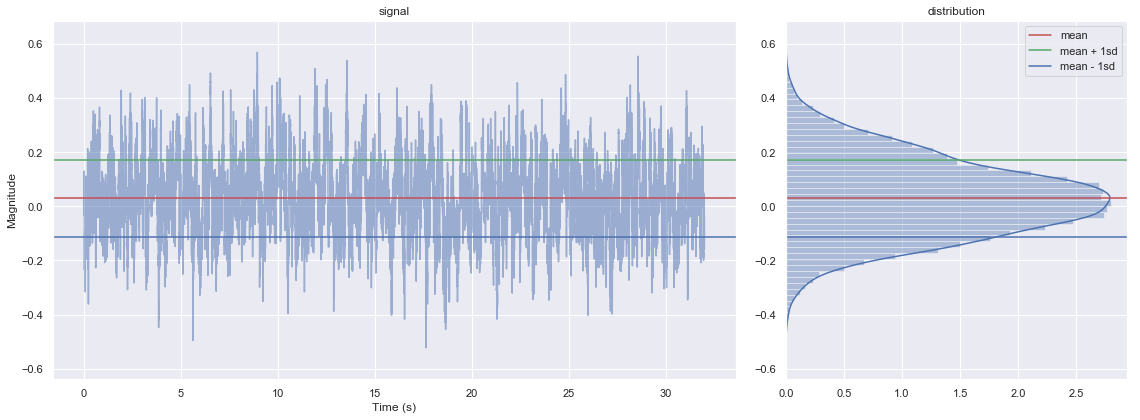

In [33]:
# visualise the data 
def visualise(df):
    mean = df['signal'].mean()
    std = df['signal'].std()
    
    fig = plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1, 2, fig, width_ratios=[2,1])

    signal_ax = plt.subplot(gs[0])
    dist_ax = plt.subplot(gs[1], sharey=signal_ax)

    signal_ax.plot(df.index, df['signal'].values, alpha=0.5); # plot the signal
    signal_ax.axhline(mean, color='r') # plot the mean
    signal_ax.axhline(mean+std, color='g') # plot the mean + 1std
    signal_ax.axhline(mean-std, color='b') # plot the mean - 1std
    
    
    sns.distplot(df['signal'].values, norm_hist=True, vertical=True, ax=dist_ax); # plot the distribution
    dist_ax.axhline(mean, color='r', label="mean") # plot the mean
    dist_ax.axhline(mean+std, color='g', label="mean + 1sd") # plot the mean + 1std
    dist_ax.axhline(mean-std, color='b', label="mean - 1sd") # plot the mean - 1std
    
    # set labels
    signal_ax.set_title("signal")
    signal_ax.set_xlabel("Time (s)") 
    signal_ax.set_ylabel("Magnitude")
    
    dist_ax.set_title("distribution")
    dist_ax.set_ylabel(None)
    dist_ax.legend(loc='upper right')

    plt.tight_layout()

# ignore the future warning error about tuples it is from the plot code
visualise(ch0_signal_df)

The signal looks like a normally distributed stationary signal. 

for further information into the characteristics of the signal we can investigate the autocorrelation and partial autocorrelation of the signal as well as comparing the signal to the normal distribution. 

This however is of no consequence for our purposes, but we will do it anyway.

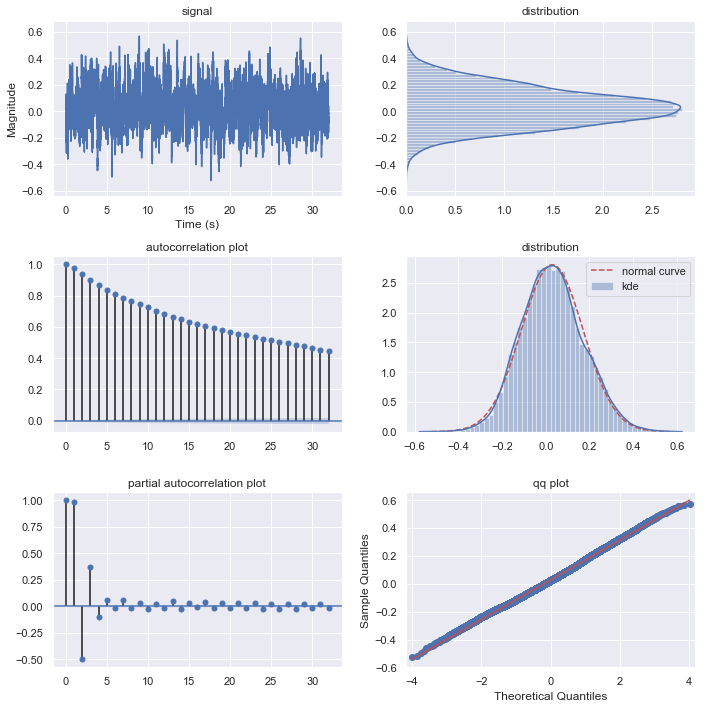

In [79]:
def plot_diagnostics(df, lags=None):
    """
    visualise the correlations
    i can't remember where i found this combination of plots but it's a pretty useful set of plots
    [         signal        ]
    [    autocorrelation    ]
    [partial autocorrelation]
    [        qq plot        ]
    
    """ 
    #constants
    mu = df['signal'].mean()
    sigma = df['signal'].std()
    signal_max = df['signal'].max()
    signal_min = df['signal'].min()
    
    # set up axis
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(3, 2, fig)
    
    # set axes
    signal_ax = plt.subplot(gs[0, 0]) # axis for plotting signal
    vdist_ax = plt.subplot(gs[0, 1], sharey=signal_ax) # axis for plotting distribution next to signal
    hdist_ax = plt.subplot(gs[1, 1]) # axis for plotting distribution above qqplot
    qqplot_ax = plt.subplot(gs[2, 1]) # qq plot axis
    
    acf_ax = plt.subplot(gs[1, 0]) # autocorrelation axis
    pacf_ax = plt.subplot(gs[2, 0]) # partial autocorrelation axis
    
    # plot signal
    signal_ax.plot(df['signal'])
    signal_ax.set_title("signal")
    signal_ax.set_xlabel("Time (s)") 
    signal_ax.set_ylabel("Magnitude")
    
    # v distribution
    sns.distplot(df['signal'], norm_hist=True, vertical=True, ax=vdist_ax); # plot the distribution
    vdist_ax.set_title("distribution")
    vdist_ax.set_ylabel(None)
    vdist_ax.set_xlabel(None)
    
    # h distribution
    xx = np.arange(signal_min, signal_max, 0.01)                                                   
    yy = stats.norm.pdf(xx, mu, sigma)  
    
    hdist_ax.plot(xx, yy, 'r--', label='normal curve')
    sns.distplot(df['signal'], norm_hist=True, vertical=False, ax=hdist_ax, label='kde'); # plot the distribution
    
    hdist_ax.set_title("distribution")
    hdist_ax.set_ylabel(None)
    hdist_ax.set_xlabel(None)
    hdist_ax.legend(loc='upper right')
    
    # qq plot
    sm.qqplot(df['signal'].values, line='s', dist='norm', ax=qqplot_ax)
    qqplot_ax.set_title("qq plot")
    
    # acf plot
    sm.tsa.graphics.plot_acf(df['signal'], ax =acf_ax, lags=lags, alpha=0.5)
    acf_ax.set_title("autocorrelation plot")
    
    # pacf plot
    sm.tsa.graphics.plot_pacf(df['signal'], ax=pacf_ax, lags=lags, alpha=0.5)
    pacf_ax.set_title("partial autocorrelation plot")
    
    plt.tight_layout()
    
plot_diagnostics(ch0_signal_df, lags=32)

## Observations
note that these are based on channel 0. 
other channels produce bad results using this analysis method. change TEST_CHaNNEL_DATA to 15 which is very left skewed

Autocorrelation plot
    Observations:
        - there a decaying correlation of the signal 
        - the decay doesn't seem to drop off
    
    Deductions:
        - this is is typical of a "random walk" process, where each time step is dependant on the previous timestep
        - this is true of a fluctuating process such as pressures from turbulent winds
        - the partial correlation will break the correlations down
        
Partial Correlation plot
    Observations:
        - Strong positive correlation with lag=1, ~ 0.9 
        - Strong negative correlation with lag=2, ~ -0.7
        - Moderate positive correlation with lag=3, ~ 0.5
        - Moderate negative correlation with lag=4, ~ -0.2
    Deductions:
        - this reveals something about the frequency of the signal and the tendency to revert
        - the signal could be modelled by an AR(4) model with weights (0.9, -0.7, 0.5, -0.2)

Distribution and qq plot
    Observations:
        - The data fits a normal distribution in the middle of the distrpibution but not the tails
        - the data shows that the tails don't fit the normal distribution very well 
            - the positive tails are light/thin (fewer observations than expected)
            - the negative tails are heavy/fat (more observations than expected)
            - this could possibly mean a slight right skew

In [6]:
def normal_test(signal, alpha=0.05):
    """
    from the scipy.stats documentation
    This function tests the null hypothesis that a sample comes from a normal distribution. 
    
    It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis 
    to produce an omnibus test of normality.
    """
    z, p = stats.normaltest(signal)
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected") # i.e. not normal
    else:
        print("The null hypothesis cannot be rejected") # i.e. possible normal

normal_test(ch0_signal_df['signal'])

NameError: name 'ch0_signal_df' is not defined

## estimating peaks using level crossing method

## Theory

The normalised crossing method. 

It is assumed that the number of level-crossings can be modelled with a Poisson process. 

From the Poisson Distribution
\begin{align}
P(n,v) &= \frac{(vT)^n}{n!}e^{(-vT)} \\
\text{where:} &\\
 n &= \text{number of crossings} \\
v &= \text{average rate of crossings} \\
T &= \text{time period} \\
\end{align}

If we are modelling the peak value $x$ for the time period $T$, then we are looking for the probability of getting no crossings $n=0$ of level $x$ for the period $T$. i.e. $F(x) = P(0,v)$

Therefore: $F(x)$ =
\begin{align}
P(0,v) &= \frac{(vT)^0}{0!}e^{-vT} \\
&= e^{-vT}
\end{align}

This of the form of a Type I EV distribution (Gumbel Distribution):
\begin{align}
F(x) &= e^{-e^{-\frac{1}{a}(x-u)}} 
\end{align}

Therefore the original problem, the probability that a peak value $x$ will not be crossed $n=0$ can be modelled by a Type I EV distribution if we take the average number of crossings of level $x$ in time $T$ (i.e. average crossing rate * time period) to be given by:
\begin{align}
vT &= e^{-\frac{1}{a}(x-u)}
\end{align}
taking the log of both sides
\begin{align}
ln(vT) &= -\frac{1}{a}(x-u)
\end{align}
___
### side note 
in the literature, $a$ is called the dispersion and $u$ is called the mode. These terms are confusing. $-\frac{1}{a}$ is the slope and $\frac{u}{a}$ is the intercept. 
___
We can now fit the log of the crossing rate $ln(vT)$ against the crossing levels x to get the parameters of the type 1 Gumbel Distribution and calculate the probability of exceedance from F(x)






## Procedure in practice

- Up-crossing (down-crossing) rate = the number of crossings of a level, with a positive (negative) slope per unit time.


- Peak factor: $g$
\begin{align}
    &\hat{x} = \mu + g\sigma \\
    &\hat{x} = \text{peak}  \\
    &\mu = \text{mean} \\
    &g = \text{peak factor} \\
    &\sigma = \text{standard deviation}\\
\end{align}


- Direct Extreme Value anlaysis method (Gumbel Method): There exists a relationship between extreme value and probability. 
    $\text{Extreme Value} = U + \frac{1}{a} ln(P)$
    
    Gumbel wording:
    
\begin{align}    
    &U = \text{Mode or y-intercept of linear fit}  \\
    &\frac{1}{a} = \text{dispersion or slope of linear fit} \\
\end{align}

    
- Hourly Peak - P* = U + y/a. Defined by Davenport from the gumbel analysis. 
\begin{align}
    P^* &= U + \frac{\gamma}{a}\\
    P^* &= \text{Hourly peak}  \\
    U &= \text{Mode or y-intercept of linear fit}  \\
    \frac{1}{a} &= \text{dispersion or slope of linear fit} \\
    \gamma &= 0.5772  = \text{Euler Constant} \\
\end{align}

  ----
Four Steps to the level crossing method:
    1. count the crossings for a range of threshold values (the levels)
    2. determine the crossing rate for each threshold value
    3. regress the log of the crossing rate against the threshold values
    4. use the linear model to predict a peak value for a given probability

### Steps 1 and 2:
count the crossings for a range of threshold values (the levels) and determine the crossing rate for each threshold value

In [ ]:
def crossings(df, sample_len, std_level_range = np.arange(0,5,0.1), isUpX = True, minimum_count=3):
    #TODO: make this a class with plotting methods
    """ 
    a dataframe that counts the level crossings of an input df 
    
    params:
    df: dataframe
        signal dataframe
    sample_len: float
        length of the signal in seconds
    std_level_range: array-like (optional)
        range of std values to be used to create the threshold levels
    isUpX: boolean (optional)
        if true, up crossings, else down crossings
        this determines the directions 
    minimum_count: int (optional)
        this determines the minimum count to be used in the analysis
        e.g. if the minimum count is 3 then thresholds up to the first crossing count of 3 will be used
    
    returns: 
    summary: dataframe
        summary dataframe of the crossings 
        
    """
    
    mean = df['signal'].mean()
    std = df['signal'].std()
    
    crossings_df = pd.DataFrame(columns=['std_levels', 'value_levels', 'crossings', 'crossings_rate'])
    crossings_df['std_levels'] = std_level_range
    
    signal = df['signal'].values.reshape(-1,1)
    
    if isUpX:
        levels = (mean + std * std_level_range).reshape(1,-1)
        c = (np.diff((signal <= levels).astype(np.int), axis=0)==1).sum(axis=0)
    else:
        levels = (mean - std * std_level_range).reshape(1,-1)
        c = (np.diff((signal >= levels).astype(np.int), axis=0)==1).sum(axis=0)
        
    crossings_df['value_levels'] = levels.reshape(-1,1)
    crossings_df["crossings"] = c
    
    # determine crossing rate = crossings / second
    # TODO: determine this from the index of the df
    crossings_df['crossings_rate'] = crossings_df['crossings'] / sample_len 
    
    # apply minimum_count rule  
    # note the rule should remove all counts past the first crossing count less than the minimum_count
    # the following will not work if there are more crossings for higher thresholds 
    #     crossings_df['crossings'].replace(range(minimum_count+1), np.nan, inplace=True)
    
        #TODO: figure out a nicer way to do this
    minimum_count_filter = crossings_df[crossings_df['crossings']<=minimum_count]
    if len(minimum_count_filter) > 0:            
        crossings_df.drop(index=range(minimum_count_filter.index[0], 
                                      crossings_df.index[-1]+1),
                          inplace=True)
        
    # the log of the crossing rate
    crossings_df['ln_rate'] = np.log(crossings_df['crossings_rate'])

    return crossings_df

ch0_crossings_df = crossings(ch0_signal_df, TEST_DATA_SAMPLE_LEN, isUpX=TEST_DATA_isUpX, minimum_count=3)
ch0_crossings_df.tail()

The crossings_df has had a minimum count threshold applied to it, where the maximum level used needs at least 3 crossings. 

This is to ensure that we fit the data to the body and don't include spurious events.

### step 3:
regress the log of the crossing rate against the threshold values 

In [ ]:
def build_linear_model(y, x, add_constant=True):
    '''
        Linear regression model
        returns the fit model
    '''
    if add_constant:
        x = sm.add_constant(x)
        
    model = sm.OLS(y, x).fit()
    return model 


def linear_fit_model(crossings_df, lower_level=1.0, upper_level=None, verbose=False):
    """
        create the linear model
        use np.polyfit or sm.ols because why not
        
        params: 
        crossings_df: df
            the crossings df calculated in steps 1 and 2. TODO: put this in a class
        
        lower_level: float (optional) default=1.0
            the lower bound of standard deviation to include in the linear fit

        upper_level: float (optional) default=3.0
            the upper bound of standard deviation to include in the linear fit

        returns: slope of the model, intercept of the model, and the data used in the fit
    """
    # Select the 
    if upper_level is None:
        data_linear_region = crossings_df[(crossings_df['std_levels'] >= lower_level)]
    else:
        data_linear_region = crossings_df[(crossings_df['std_levels'] >= lower_level) & 
                                          (crossings_df['std_levels'] <= upper_level)]

    model = build_linear_model(x=data_linear_region['ln_rate'], y=data_linear_region['std_levels'])
    if verbose:
        print(model.summary())
    slope = model.params[1]
    intercept = model.params[0]
    
    return slope, intercept, data_linear_region

slope, intercept, data_linear_region = linear_fit_model(ch0_crossings_df, lower_level=1.0, upper_level=None, verbose=True)

### step 4:
use the linear model to predict a peak value for a given probabilityh threshold value

In [ ]:
def get_hourly_peak_factor(slope, intercept, sample_len, verbose=False):
    """
        calculate the hourly peak factor from the linear model
        i don't know who came up with this but it's apparently true

        Direct EVT analysis (Gumbel)

        hourly peak P* = U + y / a
        mode    = the intercept of the ln(p) vs std_level
                = peak_factor @ ln(1/sampletime)
                = slope * ln(1/sample_time) + intercept

        dispersion = y/a
        dispersion = -1/slope of the ln(p) vs Y

        peak factor = mode + 0.5772 / dispersion
        0.5772 is the euler-mascheroni constant
        
    """
    # TODO: cleanup this nonsense and find a better source for the method
    # this section is really poorly written and copied straight from nick's notes
    
    mode = intercept + slope * np.log(1/sample_len)
    dispersion = -1/slope
    peak_factor = mode + K/dispersion
    if verbose:
        print(f"mode:\t\t{mode:2.2f}\ndispersion:\t{dispersion:2.2f}\npeak_factor:\t{peak_factor:2.2f}\n")
        
    return peak_factor

hourly_peak_factor = get_hourly_peak_factor(slope, intercept, TEST_DATA_SAMPLE_LEN, verbose=True)
peak_pressure_coefficient = ch0_signal_df['signal'].mean() + hourly_peak_factor*ch0_signal_df['signal'].std() * (1 if TEST_DATA_isUpX else -1)

print(f"the peak hourly value is {peak_pressure_coefficient:2.2f}")

In [ ]:
def plot_peak_factor(crossings_df, sample_len, lower_level=1.0, upper_level=None):
    """
    plot the crossings df
    """

    slope, intercept, data_linear_region = linear_fit_model(crossings_df, lower_level=lower_level, upper_level=upper_level)
    hourly_peak_factor = get_hourly_peak_factor(slope, intercept, TEST_DATA_SAMPLE_LEN, verbose=False)
    
    fit_y_lower = min(data_linear_region['std_levels'])
    fit_x_lower = (fit_y_lower - intercept)/slope
    fit_y_upper = max(data_linear_region['std_levels'])
    fit_x_upper = (fit_y_upper - intercept)/slope
    peak_y = hourly_peak_factor
    peak_x = (peak_y - intercept)/slope
    
    fig, ax = plt.subplots(figsize=(8,8));
    ax.scatter(crossings_df['ln_rate'], crossings_df['std_levels']);
    ax.scatter(data_linear_region['ln_rate'], data_linear_region['std_levels']);

    ax.plot([fit_x_lower, fit_x_upper], [fit_y_lower, fit_y_upper], 'r-', label=f"fit {fit_y_lower:2.2f} to {fit_y_upper:2.2f}sd")
    ax.plot([fit_x_upper, peak_x], [fit_y_upper, peak_y], 'r--', label=f"extrapolated {fit_y_upper:2.2f} to {peak_y:2.2f}sd")
    ax.scatter(peak_x, peak_y, color='r', label=f"peak predicted at {peak_y:2.2f}sd")
    
    ax.set_xlabel("ln_rate")
    ax.set_ylabel("std_levels")
    ax.legend(loc='upper right')
    
plot_peak_factor(ch0_crossings_df, TEST_DATA_SAMPLE_LEN, lower_level=1.0, upper_level=None)

## Comments

The hourly peak factor is estiamated as 4.58
This corresponds to a peak hourly value of 0.68.

The fitted data doesn't look very linear. 
   
Lets try again for a different sensor

In [ ]:
channel = 15
lower_level = 1.0
upper_level = None
isUpX=False
minimum_count = 0
ch15_signal_df, ch15_summary_df = load_data(TEST_DATA_CSV_PATH, TEST_DATA_SUMMARY_CSV_PATH, channel=channel, sample_rate=1024)
ch15_crossings_df = crossings(ch15_signal_df, TEST_DATA_SAMPLE_LEN, isUpX=isUpX, minimum_count=minimum_count)
slope, intercept, data_linear_region = linear_fit_model(ch15_crossings_df, lower_level=lower_level, upper_level=upper_level, verbose=True)

print(f"the peak hourly value is {peak_pressure_coefficient:2.2f}")

plot_diagnostics(ch15_signal_df, lags=32)
plot_peak_factor(ch15_crossings_df, sample_len=32, lower_level=lower_level, upper_level=upper_level)
hourly_peak_factor = get_hourly_peak_factor(slope, intercept, TEST_DATA_SAMPLE_LEN, verbose=True)
peak_pressure_coefficient = ch15_signal_df['signal'].mean() + hourly_peak_factor*ch15_signal_df['signal'].std() * (1 if isUpX else -1)

print(f"the peak hourly value is {peak_pressure_coefficient:2.2f}")

it is clear from this anlaysis that not all pressure sensors are equal

## Full data set analysis

Analyse every sensor at once

In [ ]:
# load time trace data for all pressure sensors
# TODO: put this into a single class for easy manipulation
# TODO: merge this with other load data function
# TODO Speed this up


def load_full_data(data_csv_path, summary_csv_path, channel=None, sample_rate=1024):    
    """ load data into dataframe """
    if channel is None:
        signal_df = pd.read_csv(data_csv_path, header=None, sep='\t', skipinitialspace=True)
    else:
        signal_df = pd.read_csv(data_csv_path, header=None, sep='\t', skipinitialspace=True, usecols=[channel])

        
    #signal_df.columns = ["signal"]
    
    summary_df = pd.read_csv(summary_csv_path, sep='\t', skipinitialspace=True, skiprows=1)
    summary_df.drop(columns=["Channel"])
    
    if channel is not None:
        summary_df = summary_df.loc[channel].to_frame()
    
    else:
        signal_df.columns = summary_df['Tap_Id']
        signal_df = signal_df[signal_df.columns[signal_df.columns!="NIL"]]   
        
    # create time vector for index
    signal_df['time'] = (signal_df.index + 1)/ sample_rate
    signal_df.set_index('time', inplace=True)

    summary_df = summary_df[summary_df["Tap_Id"]!="NIL"]

    
    return signal_df, summary_df

def _load_all_test_data():
    """ load test data into dataframe """
    return load_full_data(TEST_DATA_CSV_PATH, TEST_DATA_SUMMARY_CSV_PATH, channel=None, sample_rate=TEST_DATA_SAMPLE_RATE)

full_signal_df, full_summary_df = _load_all_test_data()
print(full_signal_df.head())
print(full_summary_df.columns)
print(full_summary_df.head())

In [ ]:
full_summary_df['Mean']
full_signal_df.mean()

mean = full_summary_df['Mean'].values.reshape(1,-1)
std = full_summary_df['Std'].values.reshape(1,-1)
    
    
std_level_range = np.arange(0,5,0.1).reshape(-1,1)
levels = np.expand_dims(mean + std * std_level_range, axis=1)

signal = full_signal_df.values

a = (signal <= levels).astype(np.int)
b = np.diff((signal <= levels).astype(np.int), axis=0)




c = (np.diff((signal <= levels).astype(np.int), axis=0)==1).sum(axis=1)

a.shape

In [ ]:
def full_crossings_df(data_df, summary_df, sample_len, std_level_range = np.arange(0,5,0.1), isUpX = True, minimum_count=3):
    """ full crossings df """
    mean = summary_df['Mean']
    std = summary_df['Std']
    
    mean = full_summary_df['Mean'].values.reshape(1,-1)
    std = full_summary_df['Std'].values.reshape(1,-1)
    
    std_level_range = np.arange(0,5,0.1).reshape(-1,1)
    
    signal = data_df.values
    
    # np takes care of the broadcasting. alternatively meshgrid. 
    if isUpX:
        levels = np.expand_dims((mean + std * std_level_range), axis=1)
        c = (np.diff((signal <= levels).astype(np.int), axis=0)==1).sum(axis=1)
    else:    
        levels = np.expand_dims((mean - std * std_level_range), axis=1)
        c = (np.diff((signal >= levels).astype(np.int), axis=0)==1).sum(axis=1)
    
    print(c.shape)
    full_crossings = pd.DataFrame(c, index=std_level_range, columns=summary_df['Tap_Id'])    
    ln_rates_df = np.log(full_crossings/sample_len)
    
    return full_crossings, ln_rates_df

full_crossings, ln_rates_df = full_crossings_df(full_signal_df, full_summary_df, TEST_DATA_SAMPLE_LEN, std_level_range=np.arange(1,4,0.25))

In [ ]:
ln_rates_df.head()

In [ ]:
ln_rates_df.head()

In [ ]:
def full_crossings_broadcast_df(data_df, summary_df, std_level_range = arange(0,5,0.1), isUpX = True, threshold=3):
    """ full crossings df """
    mean = summary_df['Mean'].to_frame()
    std = summary_df['Std'].to_frame()
    
    # considered normalizing the data_df 
    # data_df = (data_df - mean) / std
    # then comparing the df to the crossing levels 
    # This would be the same number of operations
    std_level_range = std_level_range.reshape((-1,1))
    
    crossing_levels = ( mean.values + std.dot(std_level_range.T)).T
    crossing_levels['std'] = std_level_range
    crossing_levels.set_index('std', inplace=True)
    crossing_levels.columns=summary_df['Tap_Id']

    #full_crossings = ((data_df <= crossing_level.values) & (data_df.shift(-1) > crossing_level.values)).sum().values

    #ln_rates_df = np.log(full_crossings/SAMPLE_LEN)
    
    return crossing_levels

crossing_levels = full_crossings_broadcast_df(data_df, summary_df)

In [ ]:
def crossings(df, sample_len, std_level_range = np.arange(0,5,0.1), isUpX = True, minimum_count=3):
    #TODO: make this a class with plotting methods
    """ 
    a dataframe that counts the level crossings of an input df 
    
    params:
    df: dataframe
        signal dataframe
    sample_len: float
        length of the signal in seconds
    std_level_range: array-like (optional)
        range of std values to be used to create the threshold levels
    isUpX: boolean (optional)
        if true, up crossings, else down crossings
        this determines the directions 
    minimum_count: int (optional)
        this determines the minimum count to be used in the analysis
        e.g. if the minimum count is 3 then thresholds up to the first crossing count of 3 will be used
    
    returns: 
    summary: dataframe
        summary dataframe of the crossings 
        
    """
    
    mean = df['signal'].mean()
    std = df['signal'].std()
    
    crossings_df = pd.DataFrame(columns=['std_levels', 'value_levels', 'crossings', 'crossings_rate'])
    crossings_df['std_levels'] = std_level_range
    
    signal = df['signal'].values.reshape(-1,1)
    
    if isUpX:
        levels = (mean + std * std_level_range).reshape(1,-1)
        c = (np.diff((signal <= levels).astype(np.int), axis=0)==1).sum(axis=0)
    else:
        levels = (mean - std * std_level_range).reshape(1,-1)
        c = (np.diff((signal >= levels).astype(np.int), axis=0)==1).sum(axis=0)
        
    crossings_df['value_levels'] = levels.reshape(-1,1)
    crossings_df["crossings"] = c
    
    # determine crossing rate = crossings / second
    # TODO: determine this from the index of the df
    crossings_df['crossings_rate'] = crossings_df['crossings'] / sample_len 
    
    # apply minimum_count rule  
    # note the rule should remove all counts past the first crossing count less than the minimum_count
    # the following will not work if there are more crossings for higher thresholds 
    #     crossings_df['crossings'].replace(range(minimum_count+1), np.nan, inplace=True)
    
        #TODO: figure out a nicer way to do this
    minimum_count_filter = crossings_df[crossings_df['crossings']<=minimum_count]
    if len(minimum_count_filter) > 0:            
        crossings_df.drop(index=range(minimum_count_filter.index[0], 
                                      crossings_df.index[-1]+1),
                          inplace=True)
        
    # the log of the crossing rate
    crossings_df['ln_rate'] = np.log(crossings_df['crossings_rate'])

    return crossings_df